# Final Exam
## Rohit Gangurde
## Collaborators : None

****
## Q. 1

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math

In [2]:
X, y = load_iris(return_X_y=True)

In [3]:
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.33,
                                          random_state=42)

In [4]:
class GMM_EM:
    
    def __init__(self, n_components, iterations=100, viz=False, 
                 stopping_criteria='iteration', tol=1e-3):
        self.n_components = n_components
        self.max_iter = iterations
        self.mu = None
        self.pi = None
        self.sigma = None
        self.ll = list()
        self.visualize = viz
        if stopping_criteria.lower() not in ['iteration', 'tolerance']:
            print('Invalid stopping criteria. Select one of the two : \n\t[1] iteration\n\t[2] tolerance\nDefaulting to iteration.')
            self.stopping_criteria = 'iteration'
        else : self.stopping_criteria = stopping_criteria.lower()
        self.tol = tol
        self.iter_params = {}
        
    def fit(self, X):
        
        """
            Initialize random params
        """
        
        self.cov = 1e-5 * np.identity(len(X[0]))
        self.mu = np.random.randint(min(X[:,0]), max(X[:,0]), size=(self.n_components, len(X[0])))
        self.pi = [1/self.n_components for _ in range(self.n_components)]
        self.sigma = np.zeros((self.n_components, len(X[0]), len(X[0])))
        
        for dim in range(len(self.sigma)): np.fill_diagonal(self.sigma[dim], 6)
        
        """
            E Step
        """
        for iter in range(self.max_iter):
            # ======== Init q_z with dim (n x k) ========== #
            q_z = np.zeros((len(X), len(self.sigma)))
            
            for mu, sig, pi, i in zip(self.mu, self.sigma, self.pi, range(len(q_z[0]))):
                sig += self.cov
                N = multivariate_normal(mean=mu, cov=sig)
                q_z[:, i] = pi * (N.pdf(X) / np.sum([pi_k*multivariate_normal(mean=mu_k, cov=sig_k).pdf(X)
                                                     for pi_k, mu_k, sig_k in zip(self.pi, self.mu, self.sigma+self.cov)], axis=0))
        
            """
                M Step
            """
            self.mu = []
            self.sigma = []
            self.pi = []

            for i in range(len(q_z[0])):
                sum_ = np.sum(q_z[:,i], axis=0)
                mu_i = (1/sum_) * np.sum(X * q_z[:,i].reshape(len(X), 1), axis=0)
                self.mu.append(mu_i)

                self.sigma.append( ( (1/sum_)*np.dot((np.array(q_z[:,i]).reshape(len(X),1)*(X - mu_i)).T, (X - mu_i)) ) + self.cov)

                self.pi.append(sum_/np.sum(q_z))
            
            self.iter_params[iter] = {'mu' : self.mu,
                                      'sigma' : self.sigma,
                                      'pi' : self.pi}
            
            log_likelihood = np.log(np.sum([k*multivariate_normal(self.mu[i],self.sigma[j]).pdf(X)
                                                for k,i,j in zip(self.pi, range(len(self.mu)), range(len(self.sigma)))]))
            if self.stopping_criteria == 'tolerance':
                if len(self.ll) > 0 :
                    if abs(self.ll[-1] - log_likelihood) < self.tol :
                        self.ll.append(log_likelihood)
                        break
            self.ll.append(log_likelihood)
        
        if(self.visualize):
            fig = plt.figure(figsize=(10,9))
            ax = fig.add_subplot(111)
            ax.set_title('Model Training')
            ax.plot(range(0, len(self.ll),1), self.ll)
            plt.xlabel('Iteration')
            plt.ylabel('Log Likelihood')
            plt.show()
            
    def predict_(self, X):
        preds = np.zeros((len(X), self.n_components))
        sum_ = np.sum([multivariate_normal(mean=mean, cov=cov).pdf(X)
                                 for mean, cov in zip(self.mu, self.sigma)])
        for mu, sig, i in zip(self.mu, self.sigma, range(self.n_components)):
            p = multivariate_normal(mean=mu, cov=sig).pdf(X) / sum_
            preds[:,i] = p
        return preds
    
    def predict_proba(self, X):
        return self.predict_(X)
    
    def predict(self, X):
        return np.argmax(self.predict_(X), axis=1)
    
    
    def log_likelihood(self): return self.ll if self.ll is not None else "Run fit before retrieving Log Likelihood"
    
    def best_iter(self): return np.argmax(self.ll)
    
    def set_params_iter(self, iter_) : 
        self.mu = self.iter_params[iter_]['mu']
        self.sigma = self.iter_params[iter_]['sigma']
        self.pi = self.iter_params[iter_]['pi']

### Example

In [5]:
gmm = GMM_EM(3, viz=True, iterations=100)

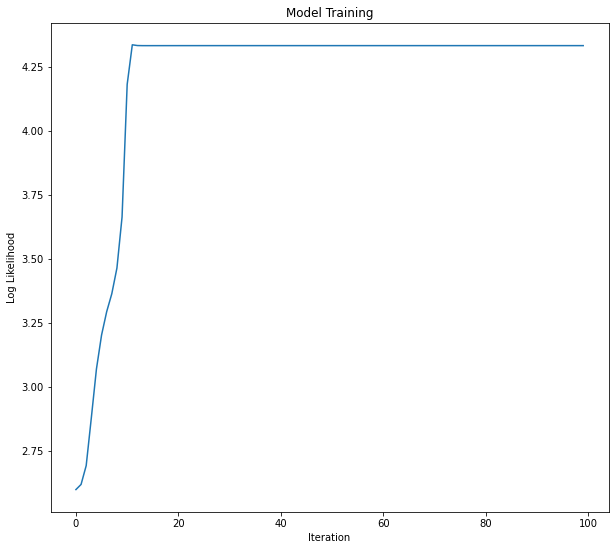

In [6]:
gmm.fit(x_tr)

In [7]:
preds = gmm.predict(x_te)
print('Accuracy score : {}'.format(accuracy_score(y_te, preds)))

Accuracy score : 0.52


In [8]:
best_iter = gmm.best_iter()

In [9]:
gmm.set_params_iter(best_iter)
preds = gmm.predict(x_te)
print('Accuracy score on iteration {} : {}'.format(best_iter,
                                                   accuracy_score(y_te, preds)))

Accuracy score on iteration 11 : 0.52


In [10]:
gmm.predict_proba(x_te)

array([[4.39915160e-087, 3.29672780e-003, 7.36050323e-005],
       [7.66970542e-003, 6.90311905e-025, 5.41320902e-017],
       [1.32161563e-265, 1.31467506e-007, 6.15008122e-007],
       [7.91752690e-081, 1.26841181e-002, 1.35928652e-002],
       [8.25513373e-104, 9.46700362e-004, 9.46832356e-003],
       [9.70787080e-003, 6.54508205e-022, 1.98460225e-011],
       [4.10743127e-045, 1.09374700e-004, 1.45491574e-003],
       [1.71661562e-141, 2.48798277e-004, 8.16718417e-022],
       [3.16353699e-096, 9.61961935e-006, 7.85424416e-005],
       [1.53901953e-055, 1.09280027e-003, 2.46682126e-002],
       [2.12507410e-120, 1.05491077e-002, 1.75344754e-007],
       [3.86726300e-002, 1.71897910e-016, 1.94870708e-012],
       [8.72832632e-003, 2.76347499e-025, 2.67009056e-015],
       [2.88107772e-002, 1.84359889e-016, 7.52808827e-014],
       [6.42049717e-002, 2.61514717e-024, 3.90865213e-016],
       [5.16969608e-088, 1.70717548e-003, 2.65007280e-003],
       [5.62638591e-164, 8.04369852e-003

### Comparing with Scikit-Learn's GaussianMixture

In [14]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3).fit(x_tr)

In [15]:
accuracy_score(y_te, gm.predict(x_te))

0.32

In [16]:
gm.predict_proba(x_te)

array([[9.66043325e-001, 1.97414020e-084, 3.39566754e-002],
       [1.52945750e-036, 1.00000000e+000, 1.14776209e-059],
       [1.79798855e-013, 4.64308873e-260, 1.00000000e+000],
       [9.95389112e-001, 1.64845501e-079, 4.61088761e-003],
       [9.98721451e-001, 7.74150853e-102, 1.27854947e-003],
       [1.28513142e-028, 1.00000000e+000, 5.27849777e-051],
       [9.99999020e-001, 2.27675196e-042, 9.80399162e-007],
       [4.31382734e-010, 1.09293979e-137, 1.00000000e+000],
       [3.68105925e-001, 6.50997202e-092, 6.31894075e-001],
       [9.99997197e-001, 3.25702224e-054, 2.80301129e-006],
       [3.16569470e-003, 3.83809929e-118, 9.96834305e-001],
       [6.89830692e-025, 1.00000000e+000, 2.32294441e-044],
       [2.16784565e-036, 1.00000000e+000, 1.45819366e-061],
       [7.46591758e-026, 1.00000000e+000, 4.97492705e-045],
       [2.36048259e-037, 1.00000000e+000, 9.21254830e-058],
       [9.99109587e-001, 3.70468072e-086, 8.90412888e-004],
       [1.93442067e-007, 2.65681158e-162